In [51]:
import sys
sys.path.append("../../preprocessing")
from drug_helper import get_trade_name_from_smiles
from rdkit import Chem
from rdkit.Chem import AllChem
import hypernetx as hnx
import matplotlib.pyplot as plt
import pandas as pd
from networkx.drawing import spring_layout

In [52]:
df = pd.read_csv('full_data.csv')

In [53]:
smiles = list(set(df['SMILES'][0:150]))

In [54]:
smiles1 = df['SMILES'][0]
smiles = df['SMILES'][0:5]

In [55]:
smiles

0         Cc1ccc(CNS(=O)(=O)c2ccc(s2)S(N)(=O)=O)cc1
1        COc1ccc(CNS(=O)(=O)c2ccc(s2)S(N)(=O)=O)cc1
2             NS(=O)(=O)c1ccc(s1)S(=O)(=O)NCc1cccs1
3      NS(=O)(=O)c1cc2C(O)CN(Cc3cccs3)S(=O)(=O)c2s1
4    COc1ccc(cc1)N1CC(O)c2cc(sc2S1(=O)=O)S(N)(=O)=O
Name: SMILES, dtype: object

In [70]:

def draw_hypergraph(hyperedges, node_labels, name,
                    special_node=None, special_shape='*'):
    """
    Zeichnet den Hypergraphen und hebt optional einen Spezialknoten hervor.
    special_node: Index des Knotens, dem special_shape zugewiesen wird.
    special_shape: Matplotlib-Shape-String (https://matplotlib.org/stable/api/markers_api.html).
    """
    H = hnx.Hypergraph(hyperedges)
    plt.figure(figsize=(40, 24))

    # Zeichne Knoten und Kanten, erhalte Positionen
    pos = hnx.draw(
        H,
        with_node_labels=True,
        node_labels=node_labels,
        with_edge_labels=True,
        fill_edges=False,
        fill_edge_alpha=-0.9,
        layout=spring_layout,
        layout_kwargs={
            'k': 1.0,         # Abstand zwischen Knoten (Standard ~1/√n)
        'scale': 10.0,    # Vergrößert das gesamte Layout
        'iterations': 200,
        'seed': 42
        },
        return_pos=True
    )

    # Spezialknoten nachzeichnen
    if special_node is not None and special_node in pos:
        x, y = pos[special_node]
        plt.scatter(
            [x], [y],
            s=300,
            marker=special_shape,
            edgecolors='black',
            linewidths=1.5,
            facecolors='white',
        )

    plt.title(f'Hypergraph of {name}')
    plt.show()


In [71]:
def create_minimal_hypergraph_with_labels(smiles, plot=True):
    """
    Minimaler Hypergraph mit Beschriftungen:
      - Gesamt-Drug-Hyperedge (Trade Name)
      - Ringe (ring_0, ring_1, …)
      - Alle Heteroatome (hetero)
      - Positive/negative Regionen (pos_charge, neg_charge)
      - Rest-Gerüst (rest)
      - Extra-Knoten für das gesamte Drug-Molekül

    Node-Labels: AtomSymbol+Index, Edge-Labels: Hyperedge-Namen
    """
    # Molekül & Basisinfos
    mol = Chem.MolFromSmiles(smiles)
    nums_atom = mol.GetNumAtoms()

    # Trade-Name bestimmen
    canonical_smiles = Chem.MolToSmiles(mol)
    trade_name = get_trade_name_from_smiles(canonical_smiles)

    # Neuen Knoten-Index für das ganze Drug-Molekül
    drug_node = nums_atom

    hyperedges = {}
    # 0) Gesamtes Molekül als Hyperedge mit Trade Name (inkl. Drug-Knoten)
    hyperedges[trade_name] = set(range(nums_atom)) | {drug_node}

    # 1) Ringe
    for i, ring in enumerate(mol.GetRingInfo().AtomRings()):
        hyperedges[f"ring_{i}"] = set(ring)

    # 2) Alle Heteroatome
    hetero = {atom.GetIdx() for atom in mol.GetAtoms()
              if atom.GetSymbol() in ('S', 'N', 'O')}
    if len(hetero) > 1:
        hyperedges["hetero"] = hetero

    # 3) Partial Charges
    AllChem.ComputeGasteigerCharges(mol)
    pos = {i for i in range(nums_atom)
           if float(mol.GetAtomWithIdx(i).GetProp('_GasteigerCharge')) > 0}
    neg = {i for i in range(nums_atom)
           if float(mol.GetAtomWithIdx(i).GetProp('_GasteigerCharge')) < 0}
    if len(pos) > 1:
        hyperedges["pos_charge"] = pos
    if len(neg) > 1:
        hyperedges["neg_charge"] = neg

    # 4) Rest-Gerüst
    covered = set().union(*hyperedges.values()) if hyperedges else set()
    rest = set(range(nums_atom)) - covered
    if len(rest) > 1:
        hyperedges["rest"] = rest

    # Node-Labels: AtomSymbol+Index + Drug-Knoten
    node_labels = {i: mol.GetAtomWithIdx(i).GetSymbol()
                   for i in range(nums_atom)}
    node_labels[drug_node] = trade_name  # Sonderlabel für Drug-Knoten

    if plot:
        draw_hypergraph(
            hyperedges,
            node_labels,
            name=trade_name,
            special_node=drug_node
        )

    return hyperedges, node_labels, trade_name


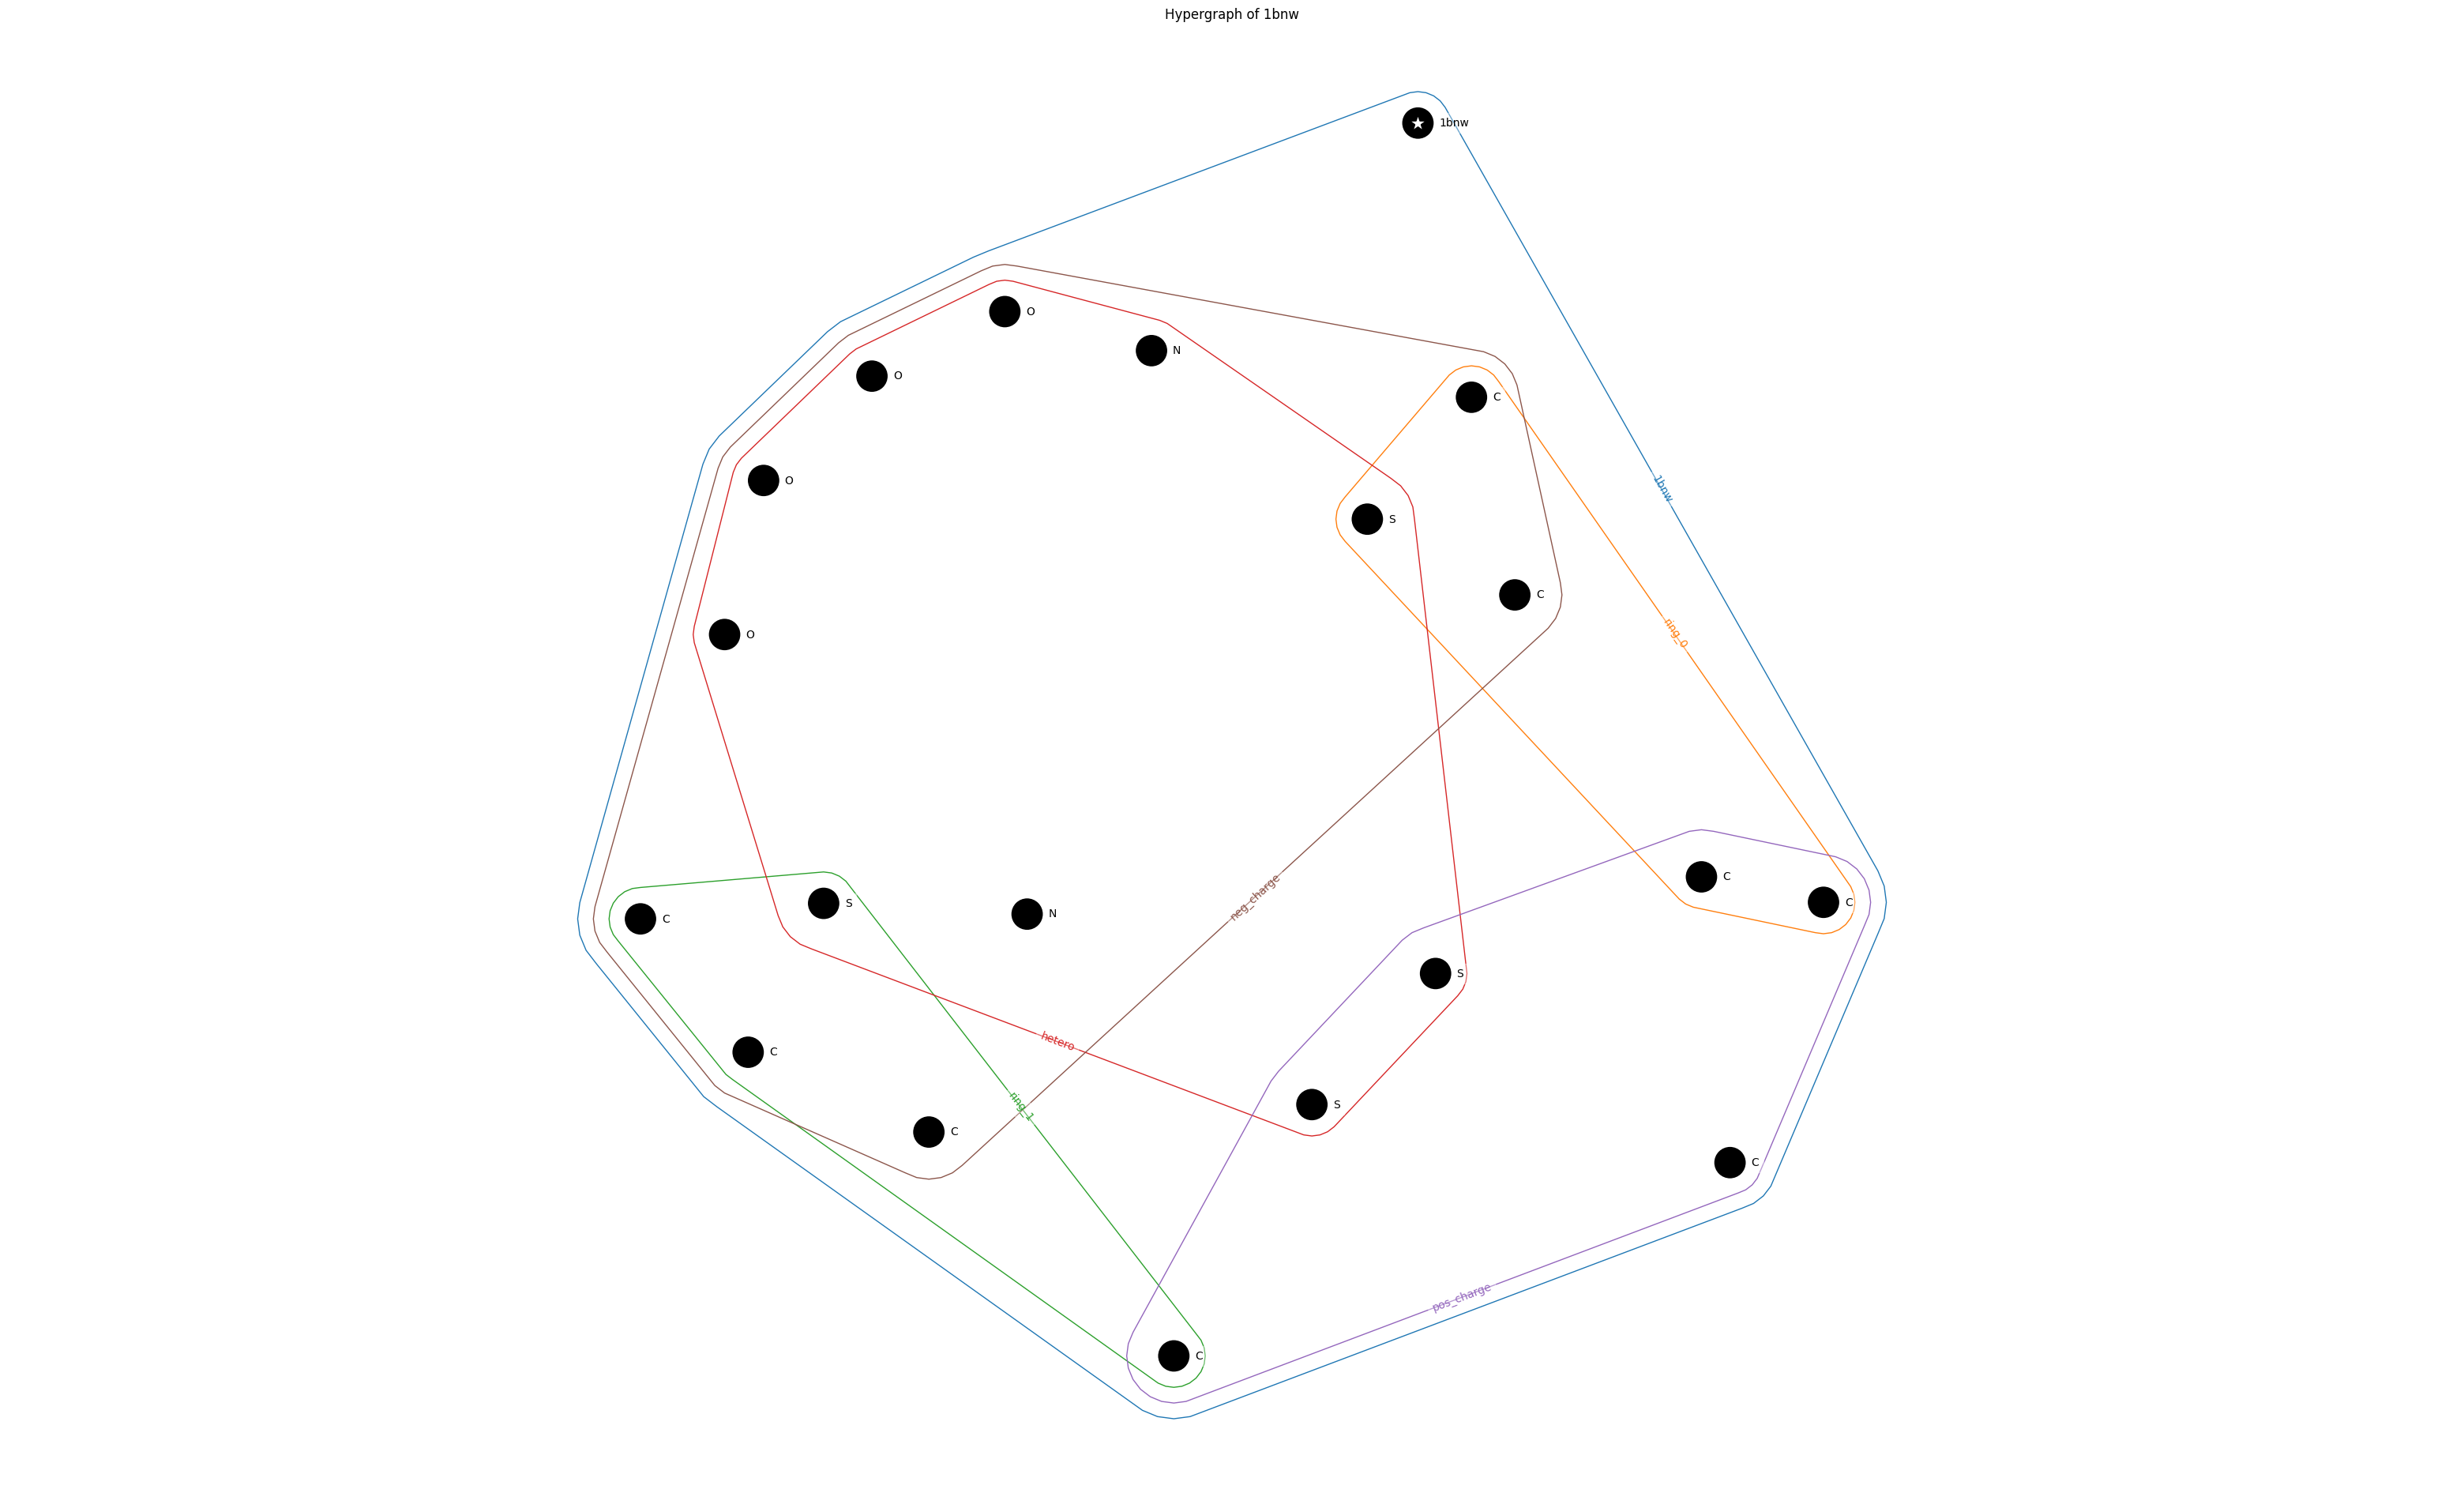

({'1bnw': {0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19},
  'ring_0': {4, 5, 6, 7, 8},
  'ring_1': {14, 15, 16, 17, 18},
  'hetero': {0, 1, 2, 3, 8, 9, 10, 11, 12, 18},
  'pos_charge': {1, 4, 7, 9, 13, 14},
  'neg_charge': {0, 2, 3, 5, 6, 8, 10, 11, 12, 15, 16, 17, 18}},
 {0: 'N',
  1: 'S',
  2: 'O',
  3: 'O',
  4: 'C',
  5: 'C',
  6: 'C',
  7: 'C',
  8: 'S',
  9: 'S',
  10: 'O',
  11: 'O',
  12: 'N',
  13: 'C',
  14: 'C',
  15: 'C',
  16: 'C',
  17: 'C',
  18: 'S',
  19: '1bnw'},
 '1bnw')

In [72]:
create_minimal_hypergraph_with_labels(smiles[2])


In [73]:
def create_shared_hypergraph_with_labels(smiles_list, plot=True):
    """
    Baut aus einer Liste von SMILES‐Strings einen gemeinsamen Hypergraphen:
      - Jeder Atomic‐Knoten (AtomSymbol+Index) sowie jeder Drug‐Knoten
        wird global indiziert und gelabelt.
      - Jede lokale Hyperedge (ring_i, hetero, pos_charge, neg_charge, rest,
        Drug‐Gesamt) wird übernommen und bekommt einen eindeutigen Key
        "{smiles}_{edge_name}".
      - Falls nach dem Zusammenführen zwei oder mehr Hyperedges exakt dieselbe
        Knotenset haben, behalten wir nur eine, löschen die Duplikate und
        „redirecten" alle anderen Hyperedges, die diese Knoten referenzieren,
        auf die eine behaltene Hyperedge.
    """
    # 1) Vorbereitung
    global_hyperedges = {}  # Dict[edge_label, list[global_node_idx]]
    helper_global_hyperedges = {}  # Dict[edge_label, list[str]]
    global_node_labels = {}  # Dict[global_node_idx, str]
    offset = 0  # Laufender Zähler zur Verschiebung der lokalen Indizes

    # 2) Pro SMILES: lokalen Graphen holen und in globalen ablegen
    for smiles in smiles_list:
        local_hyperedges, local_node_labels, trade_name = create_minimal_hypergraph_with_labels(
            smiles, plot=False
        )

        # 2a) Lokale Knoten → globale Knoten mappen
        local_to_global = {}
        local_to_global_labels = {}
        new_global_hyperedges = {}
        new_helper_global_hyperedges = {}
        already_added = []
        for local_idx, lbl in local_node_labels.items():
            global_idx = offset + local_idx
            global_node_labels[global_idx] = lbl
            local_to_global[local_idx] = global_idx
            local_to_global_labels[local_idx] = lbl

        # 2b) Lokale Hyperedges übernehmen mit neuem Label

        for edge_name, nodeset in local_hyperedges.items():
            merged_label = trade_name
            if not trade_name == edge_name:
                merged_label = f"{trade_name}_{edge_name}"
            new_global_hyperedges[merged_label] = [
                local_to_global[i] for i in nodeset
            ]
            new_helper_global_hyperedges[merged_label] = [
                local_to_global_labels[i] for i in nodeset
            ]

        # 2c) Offset um Anzahl der lokalen Knoten erhöhen
        offset += len(local_node_labels)

        for new_edge_label, new_edge_val in new_helper_global_hyperedges.items():
            for existing_label, existing_val in helper_global_hyperedges.items():
                if len(existing_val) > 5 or len(existing_val) < 3:
                    continue
                if existing_label in existing_val:
                    continue
                if existing_val == new_edge_val:
                    already_added.append(existing_label)
                    temp_translation = {}
                    for i, node_idx in enumerate(new_global_hyperedges[new_edge_label]):
                        temp_translation[node_idx] = global_hyperedges[existing_label][i]

                    for edge_label, node_ids in new_global_hyperedges.items():
                        for i, node_idx in enumerate(node_ids):
                            if node_idx in temp_translation.keys():
                                new_global_hyperedges[edge_label][i] = temp_translation[node_idx]
                    break

            helper_global_hyperedges[new_edge_label] = new_edge_val
            global_hyperedges[new_edge_label] = new_global_hyperedges[new_edge_label]

        # 3) Duplikate entfernen - nur unique Hyperedges behalten
        unique_nodesets = {}  # Dict[frozenset, edge_label]
        duplicate_edges = set()

        # Find duplicates and keep first occurrence
        for edge_label, nodes in global_hyperedges.items():
            nodeset = frozenset(nodes)
            if nodeset in unique_nodesets:
                duplicate_edges.add(edge_label)
            else:
                unique_nodesets[nodeset] = edge_label

        # Remove duplicates
        for edge_label in duplicate_edges:
            del global_hyperedges[edge_label]
    # 4) Plotten
    if plot:
        draw_hypergraph(
            global_hyperedges,
            global_node_labels,
            name="Shared Minimal Hypergraph"
        )

    # 5) Rückgabe
    return global_node_labels, global_hyperedges

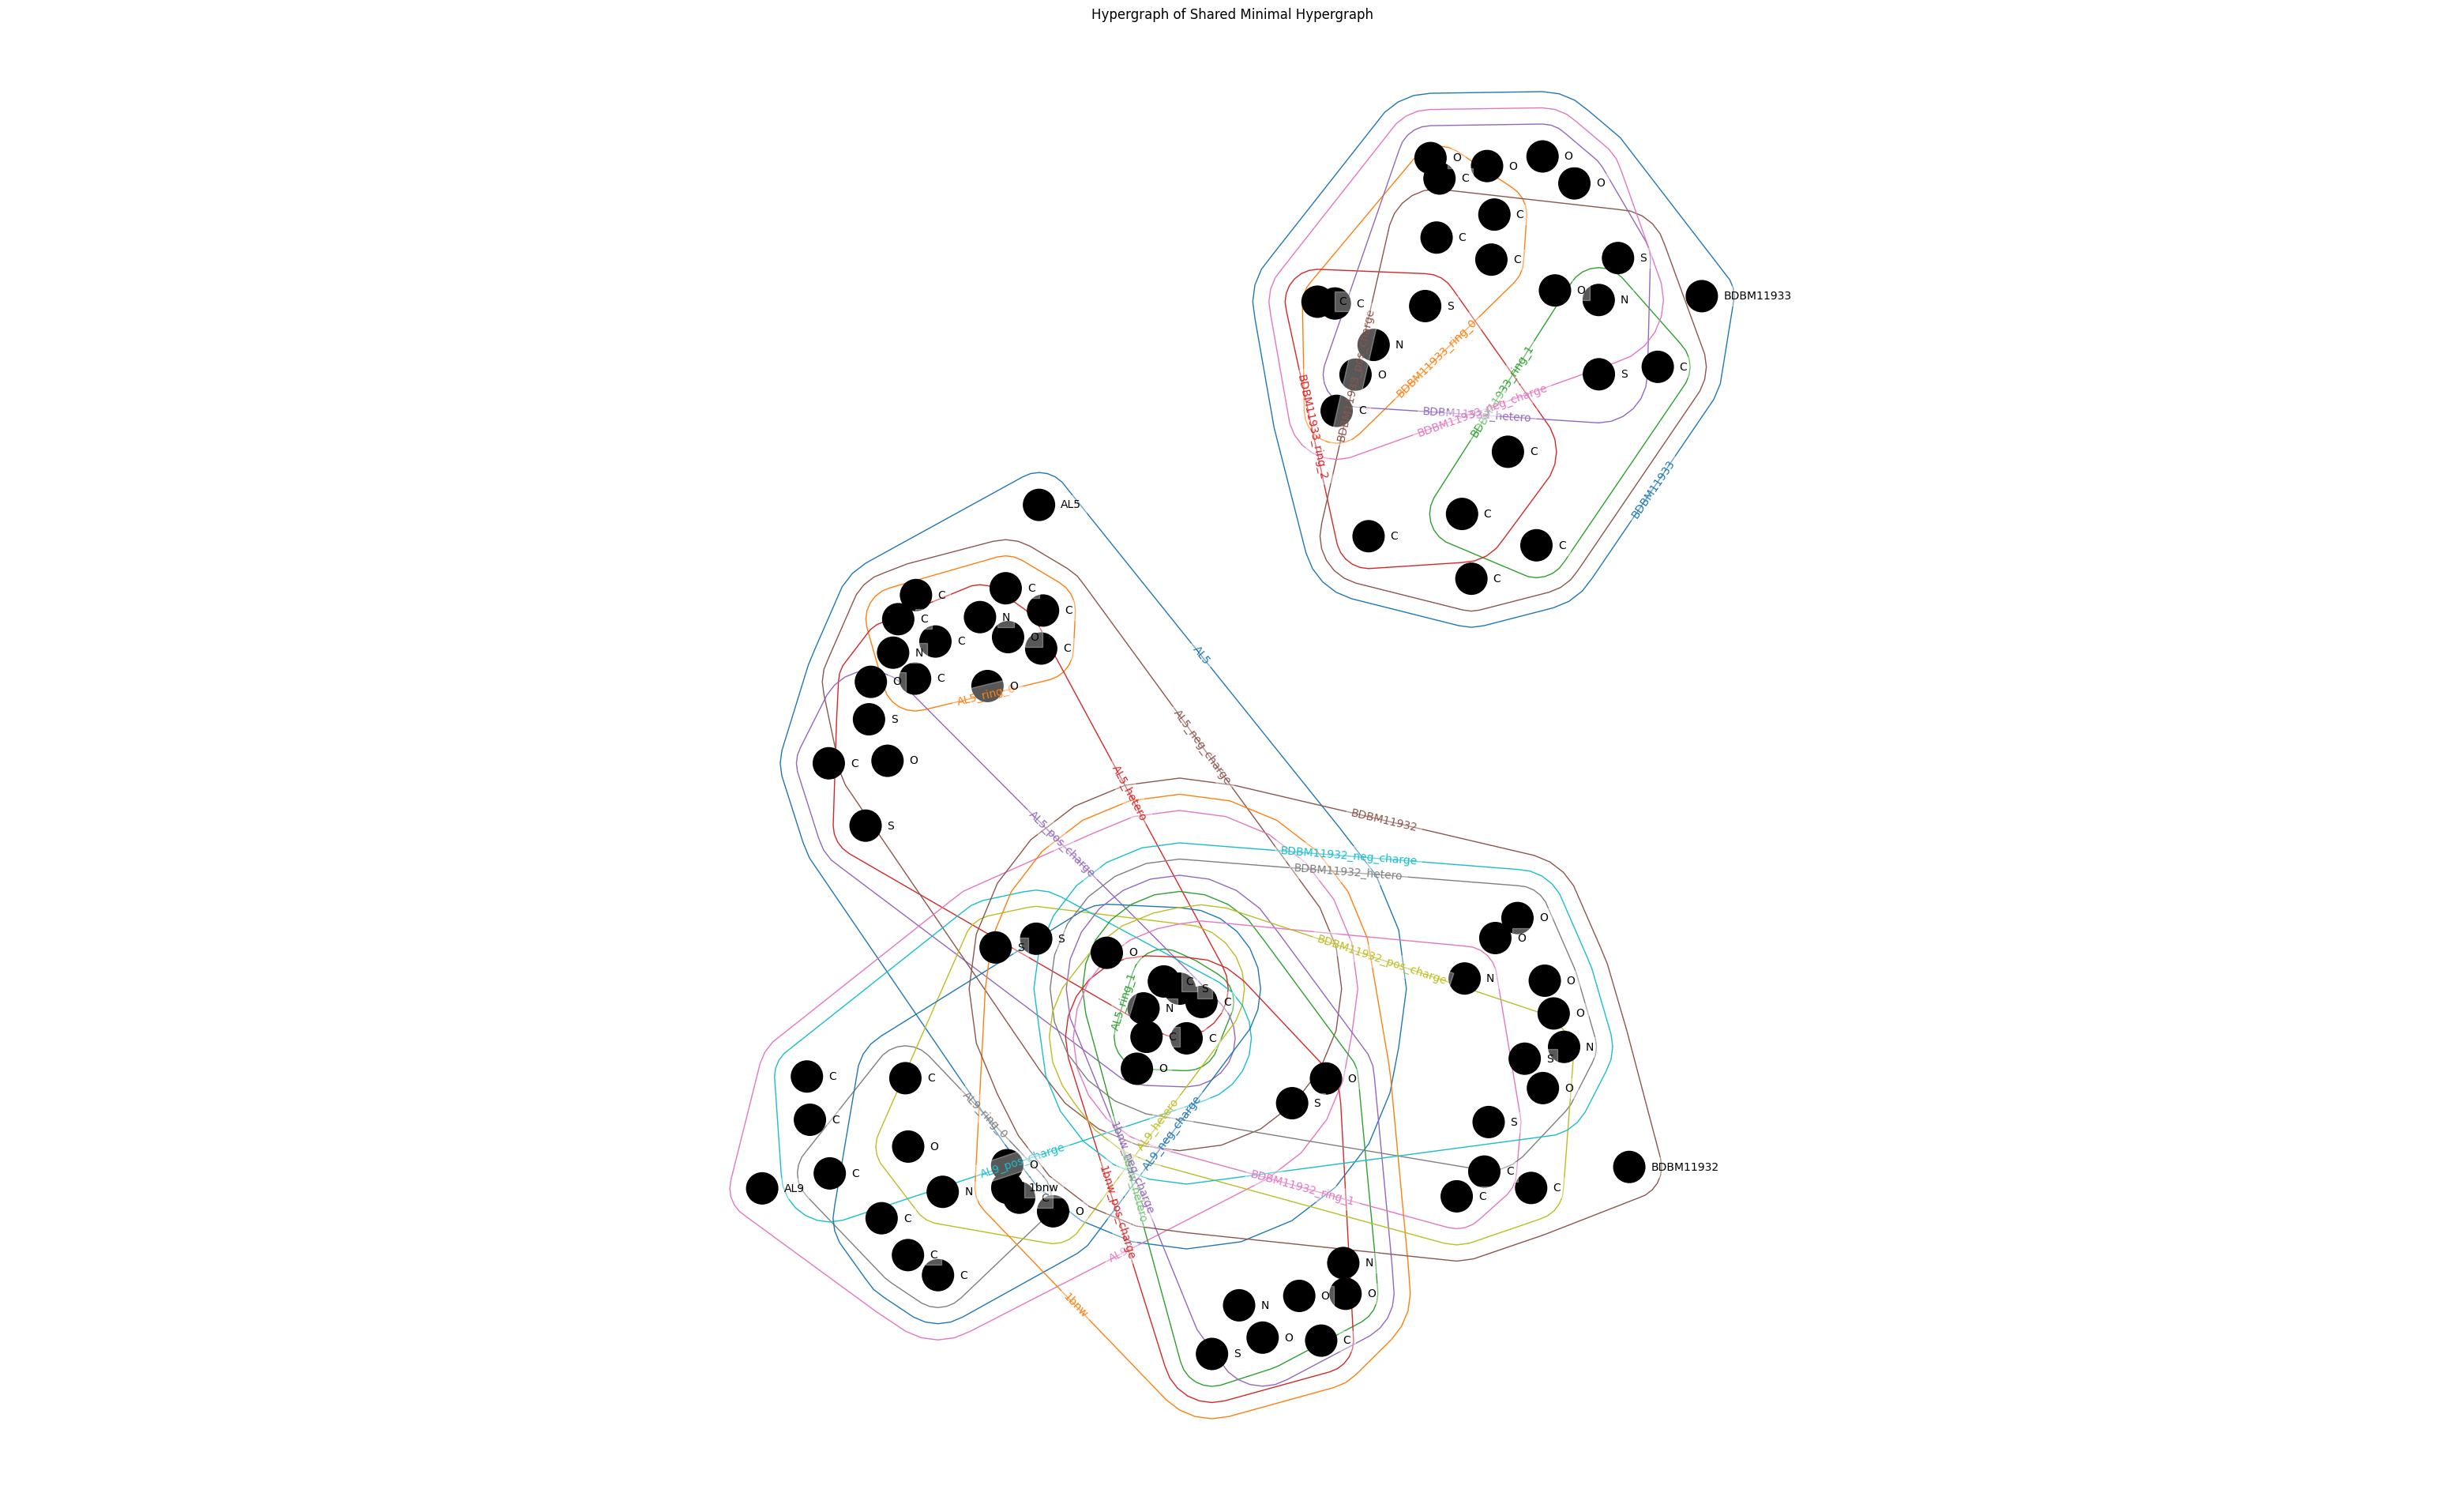

In [74]:
global_node_labels, global_hyperedges = create_shared_hypergraph_with_labels(smiles)

In [69]:
global_hyperedges

{'AL5': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21],
 'AL5_ring_0': [1, 2, 3, 4, 19, 20],
 'AL5_ring_1': [10, 11, 12, 13, 14],
 'AL5_hetero': [6, 7, 8, 9, 14, 15, 16, 17, 18],
 'AL5_pos_charge': [5, 7, 10, 13, 15],
 'AL5_neg_charge': [0, 1, 2, 3, 4, 6, 8, 9, 11, 12, 14, 16, 17, 18, 19, 20],
 'AL9': [22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  10,
  11,
  12,
  13,
  14,
  38,
  39,
  40,
  41,
  42,
  43,
  44],
 'AL9_ring_0': [24, 25, 26, 27, 42, 43],
 'AL9_hetero': [23, 29, 30, 31, 32, 14, 38, 39, 40, 41],
 'AL9_pos_charge': [22, 24, 28, 30, 10, 13, 38],
 'AL9_neg_charge': [23,
  25,
  26,
  27,
  29,
  31,
  32,
  11,
  12,
  14,
  39,
  40,
  41,
  42,
  43],
 '1bnw': [45,
  46,
  47,
  48,
  10,
  11,
  12,
  13,
  14,
  54,
  55,
  56,
  57,
  58,
  10,
  11,
  12,
  13,
  14,
  64],
 '1bnw_hetero': [45, 46, 47, 48, 14, 54, 55, 56, 57, 14],
 '1bnw_pos_charge': [46, 10, 13, 54, 58, 1